In [1]:
import numpy as np
from math import *
import scipy.special as sp
import matplotlib.pyplot as plt

In [2]:
import torch
from torch.autograd.functional import hessian

### $Powell's$ $Algorithm$

In [3]:
def golden_ratio(function, e, current, a, b, tolerance):
    c = (3 - sqrt(5)) / 2
    x1 = a + (b - a) * c
    x2 = a + b - x1

    fx1 = function(current + x1 * e)
    fx2 = function(current + x2 * e)

    while b - a > tolerance:
        if fx1 <= fx2:
            b = x2
            x2 = x1
            fx2 = fx1
            x1 = a + c * (b - a)
            fx1 = function(current + x1 * e)
            x = x1
        else:
            a = x1
            x1 = x2
            fx1 = fx2
            x2 = b - c * (b - a)
            fx2 = function(current + x2 * e)
            x = x2

    return x

In [4]:
def powell(function, helper_function, starting_position, tolerance, display_info=False, window=None, gda=0, gdb=1):
    dimension = starting_position.size
    e = np.eye(dimension)
    x = starting_position
    x1 = starting_position + 2 * 10
    num_iterations = 0
    minlist=[]

    while np.max(np.abs(x - x1)) > tolerance:
        num_iterations += 1
        current = x
        for i in range(dimension):
            theta = helper_function(function, e[:, i], current, gda, gdb, tolerance)#Calculating the minima 
            current = current + theta * e[:, i]                                     #along the dimension
        
        minlist.append(current)
        for i in range(dimension - 1):# x,y,z--> y,z,v1 and so on, this loop does the droping of direction
            e[:, i] = e[:, i + 1]
        e[:, dimension - 1] = current - x

        x1 = x
        theta = helper_function(function, e[:, dimension - 1], current, gda, gdb, tolerance)
        x = current + theta * e[:, dimension - 1]
        #minlist.append(x)

       
    fx = function(x)

    return x, fx, num_iterations,e,np.array(minlist)

### $Conjugate$ $Gradient$

In [5]:
def step_length(f, g, xk, alpha, pk, c2):
    return interpolation(f, g,
                       lambda alpha: f(xk + alpha * pk),
                       lambda alpha: np.dot(g(xk + alpha * pk), pk),
                       alpha, c2,
                       lambda f, g, alpha, c2: strong_wolfe(f, g, xk, alpha, pk, c2))

In [6]:
def wolfe(f, g, xk, alpha, pk):
    c1 = 1e-4
    return f(xk + alpha * pk) <= f(xk) + c1 * alpha * np.dot(g(xk), pk)


def strong_wolfe(f, g, xk, alpha, pk, c2):
  # typically, c2 = 0.9 when using Newton or quasi-Newton's method.
  #            c2 = 0.1 when using non-linear conjugate gradient method.
      return wolfe(f, g, xk, alpha, pk) and abs(
           np.dot(g(xk + alpha * pk), pk)) <= c2 * abs(np.dot(g(xk), pk))

In [7]:
def interpolation(f, g, f_alpha, g_alpha, alpha, c2, strong_wolfe_alpha, iters=20):
  # referred implementation here:
  # https://github.com/tamland/non-linear-optimization
    l = 0.0
    h = 1.0
    for i in range(iters):
        if strong_wolfe_alpha(f, g, alpha, c2):
            return alpha

        half = (l + h) / 2
        alpha = - g_alpha(l) * (h**2) / (2 * (f_alpha(h) - f_alpha(l) - g_alpha(l) * h))
        if alpha < l or alpha > h:
            alpha = half
        if g_alpha(alpha) > 0:
            h = alpha
        elif g_alpha(alpha) <= 0:
            l = alpha
    return alpha

In [20]:
def conjugate_gradient(f, g, x0, iterations, error):
    
    xk = x0
    c2 = 0.1

    fk = f(xk)
    gk = g(xk)
    pk = -1*gk
    count=0
    plist=[pk]
    glist=[gk]
    xmin=[]

    for i in range(iterations):
        alpha = step_length(f, g, xk, 1.0, pk, c2)
        
        xk1 = xk + alpha * pk
        gk1 = g(xk1)
        beta_k1 = np.dot(gk1, gk1) / np.dot(gk, gk)
        #print(gk)
        pk1 = -gk1 + beta_k1 * pk
        count=count+1
        plist.append(pk1)
        glist.append(gk1)
        if np.linalg.norm(xk1 - xk) < error:
            xk = xk1
            break

        xk = xk1
        gk = gk1
        pk = pk1
        xmin.append(xk)

    return xk, count, np.array(plist),np.array(glist),xmin

In [9]:
def gradx(x,y):
    return (1/np.sqrt(x**2+y**2))*(2*x*np.sqrt(x**2+y**2)  +  (-5.91365*np.sqrt(x**2+y**2) + 32.1159*x**2- 14.7841*x*y)*(np.sin(2.5*np.sqrt(x**2+y**2))) +   (-12.8464*np.sqrt(x**2+y**2) - 14.7841*x**2 -32.1159*x*y)*(np.cos(2.5*np.sqrt(x**2+y**2)))  )

In [10]:
def grady(x,y):
    return  (1/np.sqrt(x**2+y**2))*(2*y*np.sqrt(x**2+y**2) + (-12.8464*np.sqrt(x**2+y**2) + 32.1159*x*y -14.7841*y**2)*(np.sin(2.5*np.sqrt(x**2+y**2))) + (5.91365*np.sqrt(x**2+y**2)-14.7841*x*y-32.1159*y**2)*(np.cos(2.5*np.sqrt(x**2+y**2))))      

In [11]:
def gradfunc(x):
    grad=np.array([gradx(x[0],x[1]),grady(x[0],x[1])])
    return grad

### $ Difficult$ $Function $

In [12]:
def u(x,y):
    alpha=5*(1.5*np.sqrt(x**2+y**2)-1.5)
    #print(alpha)
    uval=x*np.cos(alpha)+y*np.sin(alpha)-5 
    return uval

In [13]:
def v(x,y):
    alpha=5*(1.5*np.sqrt(x**2+y**2)-1.5)
    #print(alpha)
    vval=-x*np.sin(alpha)+y*np.cos(alpha)-5
    return vval

In [14]:
def f2(x):
	return u(x[0],x[1])**2+v(x[0],x[1])**2

In [15]:
def new_func(x,y):
    return u(x,y)**2+v(x,y)**2

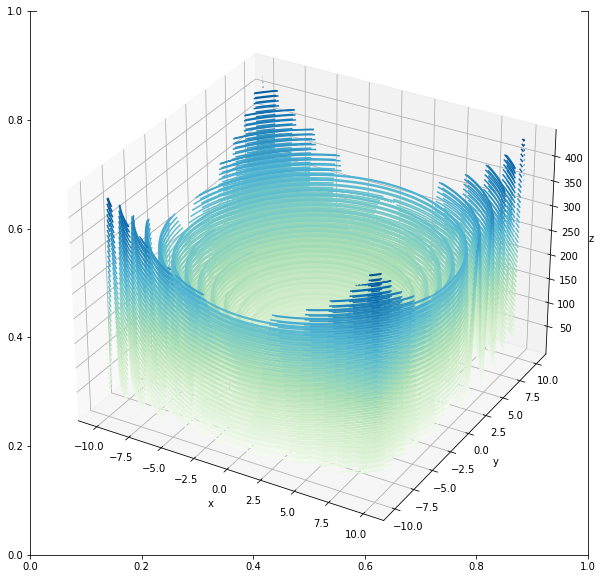

In [16]:
from mpl_toolkits import mplot3d
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)

X, Y = np.meshgrid(x, y)
Z = new_func(X, Y)
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.contour3D(X,Y,Z,50, cmap='GnBu')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Text(0, 0.5, 'y')

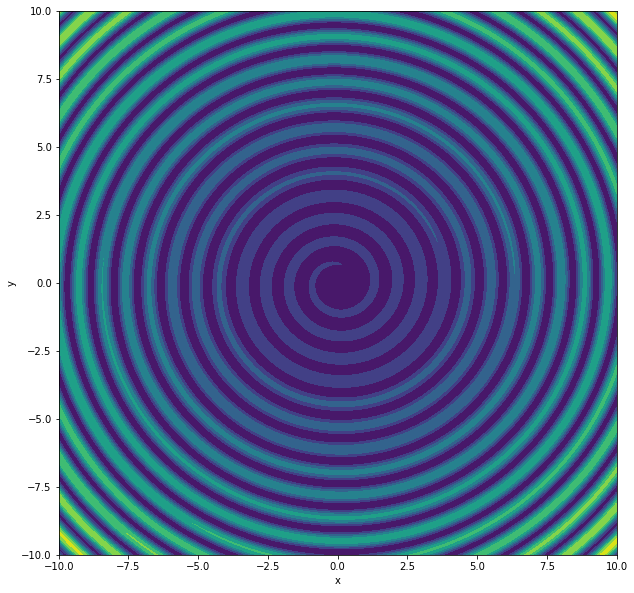

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.contourf(X,Y,Z)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [68]:
### By looking at the plot its evident that the minima is there but it's a difficult function 
### for commom methods to track the minima. So manually I cheked it in a certain range(-10,10).

zminx,zminy = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
xmin=X[zminx,zminy]
ymin=Y[zminx,zminy]
f2(np.array([xmin,ymin]))
print(xmin,ymin)

-4.814814814814815 5.175175175175175


### $Implementation :$$Conjugate $ $Gradient$

In [19]:
initial=[-1,0]
ans_conjugate_difficult=conjugate_gradient(f2,gradfunc,initial,100,1e-5)##Fletcher-reeves
#ans_conjugate_difficult

In [20]:
ans_conjugate_difficult[0]

array([ 5.08248921, -1.080901  ])

In [21]:
f2(ans_conjugate_difficult[0])

40.448638124089236

In [22]:
h=ans_conjugate_difficult[2]
g=ans_conjugate_difficult[3]

In [23]:
np.dot(h[-1],g[-1])

-1125.2208550407959

In [18]:
##Implementing the Polak-Riebere part
initial=[-1,0]
ans_polak=conjugate_gradient(f2,gradfunc,initial,20,1e-5)

In [19]:
ans_polak[0]
f2(ans_polak[0])

90317.6260966053

### Polak-Ribiere performs worse on this difficult function

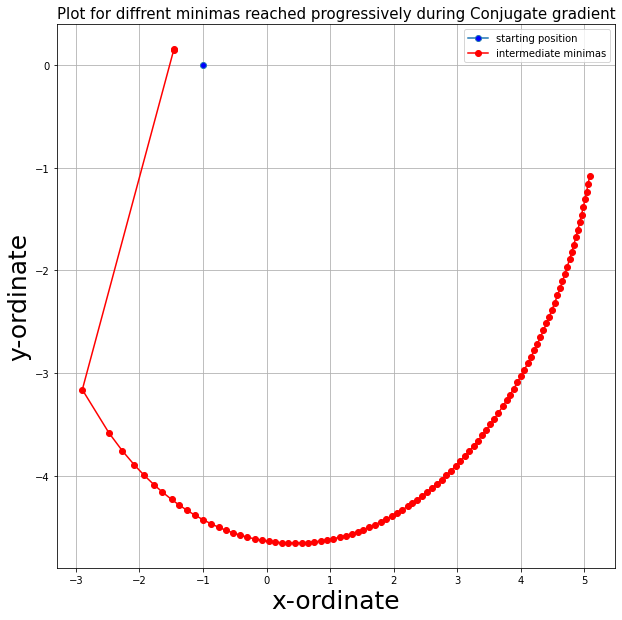

In [26]:
### Plotting the path that minimum followed for all the iterations in powell.

x=ans_conjugate_difficult[4]
xval=[]
yval=[]
for i in range(len(x)):
    xval.append(x[i][0])
    yval.append(x[i][1])
    
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(initial[0],initial[1],marker='o',markerfacecolor='blue')
plt.plot(xval,yval,color='red',marker='o')
ax.set_xlabel('x-ordinate',fontsize=25)
ax.set_ylabel('y-ordinate',fontsize=25)
plt.title("Plot for diffrent minimas reached progressively during Conjugate gradient",fontsize=15)
plt.legend(['starting position','intermediate minimas'])
plt.grid(True)

In [27]:
import scipy 
from scipy import optimize
from scipy.optimize import minimize

In [28]:
minimize(f2,np.array([-1,0]), method='CG',jac=gradfunc,tol=1e-5)#options={'tol':1e-9})

     fun: 61.0
     jac: array([ 35.81731541, -12.42589549])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 33
     nit: 0
    njev: 22
  status: 2
 success: False
       x: array([-1.,  0.])

#### The function as evident from the graph has many local minimas so CG fails to converge and thereby gets stuck at local minimas

### $Implementation :$ $Powell's$ $ Algorithm$

In [29]:
b=np.array([-1,0]).T
ans_powell_difficult=powell(f2, golden_ratio, b, 1e-5)

In [30]:
ans_powell_difficult[0]

array([-5.08176358e-01,  7.36807010e-06])

In [31]:
f2(ans_powell_difficult[0])

43.27468306969518

In [32]:
ans_powell_difficult[4]

array([[-5.08179982e-01,  3.68401469e-06],
       [-5.08176358e-01,  7.36805653e-06]])

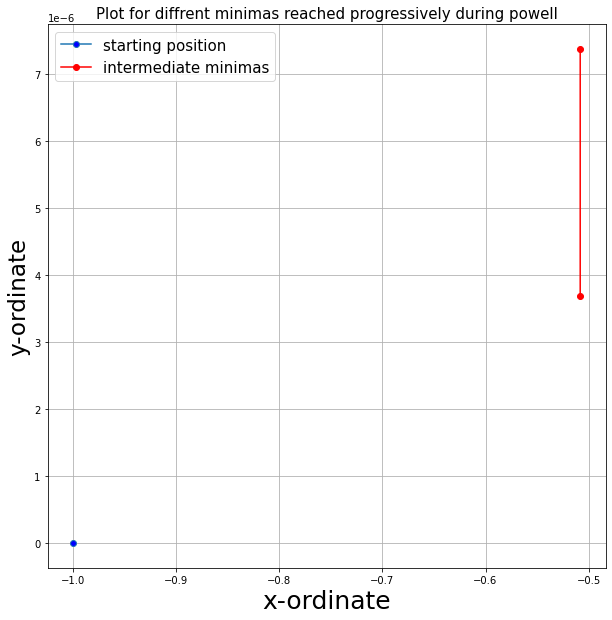

In [33]:
x=ans_powell_difficult[4]
xval=[]
yval=[]
for i in range(len(x)):
    xval.append(x[i][0])
    yval.append(x[i][1])
    
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(initial[0],initial[1],marker='o',markerfacecolor='blue')
plt.plot(xval,yval,color='red',marker='o')
ax.set_xlabel('x-ordinate',fontsize=25)
ax.set_ylabel('y-ordinate',fontsize=23)
plt.title("Plot for diffrent minimas reached progressively during powell",fontsize=15)
plt.legend(['starting position','intermediate minimas'],fontsize=15)
plt.grid(True)
plt.rcParams['legend.fontsize'] = 15

In [34]:
minimize(f2,np.array([-1,0]), method='Powell',tol=1e-5)#Scipy version

   direc: array([[ 0.04733242, -0.16780394],
       [ 0.06384455, -0.16208822]])
     fun: 23.576388937186803
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 2000
     nit: 62
  status: 1
 success: False
       x: array([-1.97160069, -1.0387207 ])

### $Implementation: $ $Gradient$ $Descent$

In [64]:
learning_rate=1e-16 #With very small learning rate Gradient descent is performing well.
pos=np.array([-1,0],dtype=np.float64)
lst=np.zeros((200,2))
for i in range(200):
    prev=f2(pos)                                                        
    delx=gradx(pos[0],pos[1])
    dely=grady(pos[0],pos[1])
    
    pos[0]-=learning_rate*delx
    pos[1]-=learning_rate*dely
    temp=pos   
    #print (pos, f2(pos),i+1)
    print(temp)
    if abs(prev-f2(pos))<1e-17:
        break
    else:
        lst[i,:]=pos
        print (abs(prev-f2(pos)))

[-1.00000000e+00  1.24258955e-15]
2.2737367544323206e-13
[-1.0000000e+00  2.4851791e-15]
2.4868995751603507e-13
[-1.00000000e+00  3.72776865e-15]
2.3447910280083306e-13
[-1.0000000e+00  4.9703582e-15]
2.4158453015843406e-13
[-1.00000000e+00  6.21294775e-15]
2.2737367544323206e-13
[-1.0000000e+00  7.4555373e-15]
2.3447910280083306e-13
[-1.00000000e+00  8.69812685e-15]
2.4158453015843406e-13
[-1.0000000e+00  9.9407164e-15]
2.3447910280083306e-13
[-1.00000000e+00  1.11833059e-14]
2.4158453015843406e-13
[-1.00000000e+00  1.24258955e-14]
2.2737367544323206e-13
[-1.0000000e+00  1.3668485e-14]
2.4158453015843406e-13
[-1.00000000e+00  1.49110746e-14]
2.4158453015843406e-13
[-1.00000000e+00  1.61536641e-14]
2.2737367544323206e-13
[-1.00000000e+00  1.73962537e-14]
2.4158453015843406e-13
[-1.00000000e+00  1.86388432e-14]
2.2737367544323206e-13
[-1.00000000e+00  1.98814328e-14]
2.4158453015843406e-13
[-1.00000000e+00  2.11240223e-14]
2.4158453015843406e-13
[-1.00000000e+00  2.23666119e-14]
2.27373

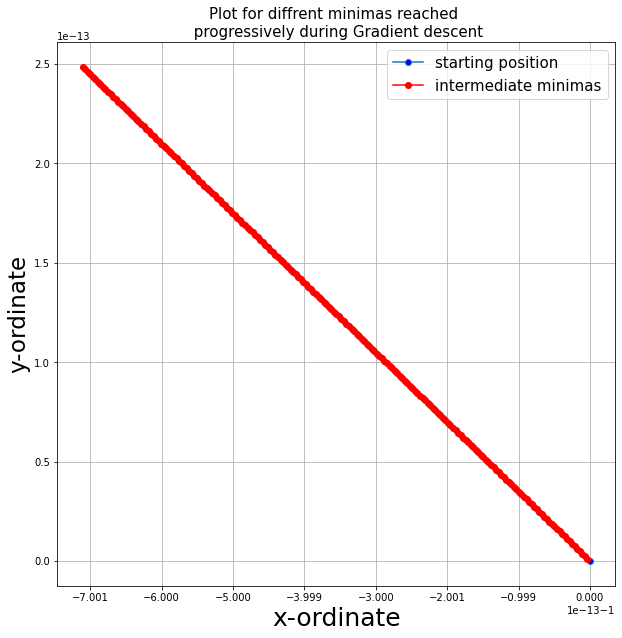

In [67]:
xval=[]
yval=[]
for i in range(lst.shape[0]):
    xval.append(lst[i][0])
    yval.append(lst[i][1])

initial=[-1,0]
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(initial[0],initial[1],marker='o',markerfacecolor='blue')
plt.plot(xval,yval,color='red',marker='o')
ax.set_xlabel('x-ordinate',fontsize=25)
ax.set_ylabel('y-ordinate',fontsize=23)
plt.title("Plot for diffrent minimas reached \n progressively during Gradient descent",fontsize=15)
plt.legend(['starting position','intermediate minimas'],fontsize=15)
plt.grid(True)
plt.rcParams['legend.fontsize'] = 15

In [39]:
xval

[-1.000000000358173,
 -1.000000000716346,
 -1.0000000010745191,
 -1.0000000014326922,
 -1.0000000017908652,
 -1.0000000021490383,
 -1.0000000025072113,
 -1.0000000028653844,
 -1.0000000032235574,
 -1.0000000035817305,
 -1.0000000039399035,
 -1.0000000042980766,
 -1.0000000046562496,
 -1.0000000050144227,
 -1.0000000053725957,
 -1.0000000057307687,
 -1.0000000060889418,
 -1.0000000064471148,
 -1.0000000068052879,
 -1.000000007163461,
 -1.000000007521634,
 -1.000000007879807,
 -1.00000000823798,
 -1.0000000085961531,
 -1.0000000089543262,
 -1.0000000093124992,
 -1.0000000096706723,
 -1.0000000100288453,
 -1.0000000103870184,
 -1.0000000107451914,
 -1.0000000111033645,
 -1.0000000114615375,
 -1.0000000118197105,
 -1.0000000121778836,
 -1.0000000125360566,
 -1.0000000128942297,
 -1.0000000132524027,
 -1.0000000136105758,
 -1.0000000139687488,
 -1.0000000143269219,
 -1.000000014685095,
 -1.000000015043268,
 -1.000000015401441,
 -1.000000015759614,
 -1.000000016117787,
 -1.0000000164759602,


In [40]:
yval

[1.2425895494096191e-10,
 2.4851790985757375e-10,
 3.7277686474983553e-10,
 4.970358196177473e-10,
 6.21294774461309e-10,
 7.455537292805206e-10,
 8.698126840753823e-10,
 9.940716388458938e-10,
 1.1183305935920553e-09,
 1.2425895483138668e-09,
 1.366848503011328e-09,
 1.4911074576844395e-09,
 1.6153664123332008e-09,
 1.739625366957612e-09,
 1.863884321557673e-09,
 1.988143276133384e-09,
 2.112402230684745e-09,
 2.2366611852117564e-09,
 2.3609201397144175e-09,
 2.4851790941927285e-09,
 2.6094380486466893e-09,
 2.7336970030763e-09,
 2.8579559574815607e-09,
 2.9822149118624715e-09,
 3.1064738662190323e-09,
 3.230732820551243e-09,
 3.3549917748591034e-09,
 3.479250729142614e-09,
 3.603509683401775e-09,
 3.727768637636585e-09,
 3.852027591847045e-09,
 3.976286546033155e-09,
 4.100545500194916e-09,
 4.224804454332326e-09,
 4.349063408445386e-09,
 4.473322362534096e-09,
 4.597581316598456e-09,
 4.721840270638466e-09,
 4.846099224654126e-09,
 4.970358178645436e-09,
 5.094617132612395e-09,
 5.2

In [46]:
initial

[-1, 0]